# Predictor 
for inpiration on the requirements I looked [here](https://docs.google.com/document/d/1ycGeb1QYKATG6jvz74SAMqxrlek9Ed4RYrzWNhWS-0Q/pub)

In [1]:
import yfinance as yf 
import pandas as pd 
import numpy as np 
import warnings
from tensorflow import keras
import matplotlib.pyplot as plt 
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.metrics import mean_squared_error
from IPython.display import clear_output

/Users/danielcornea/miniforge3/envs/arima/lib/python3.8/site-packages/statsmodels/compat/pandas.py:65: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import Int64Index as NumericIndex


## Table of Contents
<a href = "https://review.udacity.com/#!/rubrics/2345/view" > Project Rubric</a>
### [Project Definition](#proj_def)
[Project Overview](#proj_over) <br />
[Problem Statement](#problem_statement) <br />
[Metrics](#metrics) <br />

### [Analysis](#analysis)

[Data Exploration](#anal_exp) <br />
[Data Visualization](#anal_vis) <br />

### [Methodology](#methodology)

[Data Preprocessing](#met_prep) <br />
[Implementation](#met_imp) <br />
[Refinement](#met_ref) <br />


### [Results](#results)
[Model Evaluation and Validation](#res_eval) <br />
[Justification](#res_just) <br />


### [Conclusion](#conclusion)
Reflection <br /> 
Improvement <br />

<id class = "proj_def">

### Project Definition 
The project that I chose is the one described <a href = "" >here </a>. However, instead of an application I am delivering a technical blogpost which can be found <a href = "" >here </a>.

#### <a id = "proj_over">Project Overview</a> 
As a general view in this project I am attempting to build a simple stock predictor based on the power of neural networks. In this particular area I am defining the problem statement and the metrics used.
As a flow, I will be attempting to build the predictor line by line, in the refinement chapter, however, I will gather together the code used in functions.  

<p>
    The Analysis chapter is used to explore and visualize the data series
</p>
<p>
    The Methodology chapter is the core of the project, it is the place where I preprocess, implement and refine the model used for the stock predictor. As said earlier this where the whole code will be gathered together in order to use the refinement of the parameters
</p>

<p>
    In the results chapter I am analysing the results obtained
</p>

<p>
    The Conclusion chapter is where I draw the conclusions and reflect on ways to improve. 
</p>

#### <a id = "problem_statement">Problem Statement</a> 

The problem that I am attempting to solve is given by the hardship in reliably predicting the stock movements with an acceptable accuracy. In order to solve this, I am building a stock predictor model. I try to solve this by creating a model that looks at the n past closing prices and attempts to predict the next

#### <a id = "metrics">Metrics</a> 
The sole metric used is the accuracy by which the predictor can predict, based on past data, future unseen before stock quotes expressed in the mean differences between actual and predicted stock prices divided by the last stock price

### <a id = "analysis">Analysis</a> 

In this section I am analysing  and exploring the initial data that is being imported with the help of yfinance package

#### <a id = "anal_exp">Data Exploration </a> 
In this step I am importing the data and look for it's characteristics, for this we will import the data relating to Microsoft (MSFT) end of today values ("Closed")

In [2]:
#assigning the ticker to variable
msft = yf.Ticker("MSFT")
# importing data 
hist = msft.history(period="5y")

In [3]:
# looking at the first 5 rows 
hist.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2017-04-17,60.713852,61.133918,60.685849,61.124588,16689300,0.0,0
2017-04-18,60.984559,61.339280,60.825868,61.040565,15155600,0.0,0
2017-04-19,61.283282,61.376629,60.573832,60.713856,26992800,0.0,0
2017-04-20,61.105917,61.376628,60.807202,61.143257,22299500,0.0,0
2017-04-21,61.301944,62.263432,61.096576,61.983391,32522600,0.0,0


In [4]:
# making sure there are no Nan values 
hist[hist.isna().any(axis=1)]

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,


In [5]:
# selecting the "Close"
msft_close = hist[['Close']]

In [6]:
# looking at the first 5 rows
msft_close.head()

,Close
Date,
2017-04-17,61.124588
2017-04-18,61.040565
2017-04-19,60.713856
2017-04-20,61.143257
2017-04-21,61.983391


In [7]:
# the description of the 
msft_close.describe()

,Close
count,1260.000000
mean,164.923720
std,80.697962
min,60.713856
25%,97.631817
50%,136.346870
75%,222.882015
max,342.402008


#### <a id = "anal_viz">Data Visualization </a> 
Self explanatory, there is not much data to see, it is a times series that represents the meteoric rise in Microsoft

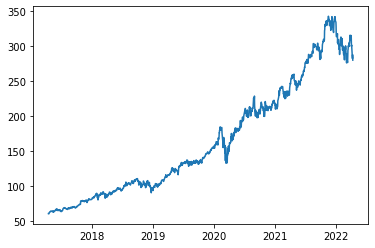

In [8]:
# displaying the timeseries
plt.plot(msft_close); 

### <a id = "methodology">Methodology</a> 
In this part I preprocess the data by adding the percentage change column and the log transformtation. This would be the actual input data. Afterwards I train the LSTM model, followed by a gathering together of all the code in functions that help in the refinement of the parameters

#### <a id = "met_prep">Data Preprocessing </a> 
In this part we are adding the log change column, which is based on the percentage change. Afterwards we proceed in creating the arrays used for the Long Short Term Memory (LSTM) fitting. As a starting point we are using an array which  is composed of block of 3 entries. Each of these entries coresponds to the change in the last 3 days. The other array will contain only the target value in the 3 + 1 days. 

Long story short, we will use the last 3 days to predict the change in the 4th day.

In [9]:
# adding the percentage change
msft_close.insert(column = "pct_change", value = msft_close.Close.pct_change(), loc = msft_close.shape[1])
# adding the log change 
msft_close.insert(column = "pct_change_log", value = np.log(1 + msft_close['pct_change']), loc = msft_close.shape[1])

In [10]:
# dropping the na values 
msft_close = msft_close.dropna()

In [11]:
# extracting only the Close and pct_log values in X Array
X = msft_close[['Close', 'pct_change_log']].values

In [12]:
# how does X look like
X[:5]

array([[ 6.10405655e+01, -1.37555650e-03],
       [ 6.07138557e+01, -5.36671323e-03],
       [ 6.11432571e+01,  7.04765056e-03],
       [ 6.19833908e+01,  1.36468704e-02],
       [ 6.30382233e+01,  1.68748020e-02]])

In [13]:
# defining the scaler 
scaler = MinMaxScaler(feature_range=(0, 1)).fit(X)

In [14]:
# Transformin the X array
X_scaled = scaler.transform(X)

In [15]:
# extracting the log stock ticker prices in y
y = [x[0] for x in X_scaled]

In [16]:
# getting the number of train items 
split = int(len(X_scaled) *0.8)


In [17]:
# getting the actuall train numbers used in training 
X_train = X_scaled[:split]


In [18]:
# getting the remaining items as test items used in training
X_test = X_scaled[split : len(X_scaled)]


In [19]:
# same thing for the items used in testing 
y_train = y[:split]
y_test = y[split : len(y)]

In [20]:
# sanity checks
assert len(X_train) == len(y_train)
assert len(X_test) == len(y_test)

In [21]:
# building the features matrixes
# last three days to predict the the fourth setting
n = 3
Xtrain, ytrain, Xtest, ytest = [], [], [], []

for i in range(n, len(X_train)-1):
    # starting at n (present case n = 3)
    # appending the last n items, meaning transformed share price and log change to Xtrain 
    Xtrain.append(X_train[i - n : i, : X_train.shape[1]])
    # appending the nth+1 transformed share price to ytrain
    ytrain.append(y_train[i+1])

for i in range(n, len(X_test)-1):
    # same as above for the test part 
    Xtest.append(X_test[i - n : i, : X_test.shape[1]])
    ytest.append(y_test[i+1])

In [22]:
# transforming to np array
Xtrain, ytrain = (np.array(Xtrain), np.array(ytrain))
# making sure the shape is the one we need
Xtrain = np.reshape(Xtrain, (Xtrain.shape[0], Xtrain.shape[1], Xtrain.shape[2]))
# same as above for the test part 
Xtest, ytest = (np.array(Xtest), np.array(ytest))
Xtest = np.reshape(Xtest, (Xtest.shape[0], Xtest.shape[1], Xtest.shape[2]))

In [23]:
# transforming everything to float32
Xtrain = Xtrain.astype(np.float32)
ytrain = ytrain.astype(np.float32)
Xtrain = Xtrain.astype(np.float32)
Xtest = Xtest.astype(np.float32)

#### <a id = "met_imp">Implementation </a> 
In this part we define the model, we predict based on the defined model and we evaluate results. As seen in the parameters, given the nature of the data, I use only one layer. 

In [24]:
# defining the model 
model = Sequential()
model.add(LSTM(4, input_shape = (Xtrain.shape[1], Xtrain.shape[2])))
model.add(Dense(1))
model.compile(loss="mean_squared_error", optimizer = "adam")
model.fit(
    Xtrain, ytrain, epochs = 50, validation_data=(Xtest, ytest), batch_size = 16, verbose = 0
)

2022-04-18 12:02:22.752669: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


In [25]:
# predicting on test data 
testPredict = model.predict(Xtest)

In [26]:
# adding a "column" of zeroes to test predictions in order to be able to feed back into transformer 
testPredict = np.c_[testPredict, np.zeros(testPredict.shape)]

In [27]:
# transforming back to actual share prices 
testPredict = scaler.inverse_transform(testPredict)
# extracting only the share prices 
testPredict = [x[0] for x in testPredict]

In [28]:
# len of testPredict 
lenTestPredict = len(testPredict)

In [29]:
# extracting the exact amount of the predicted values from the initial data set minus one, 
# as we are predicting the next day's value
train_msft_close = msft_close[-(lenTestPredict-1):]
train_msft_close = train_msft_close.Close.values
# saving the last value 
lastVal = testPredict[-1]
# dropping the last value 
testPredict = testPredict[:-1]

In [30]:
len(train_msft_close) == len(testPredict)

True

In [31]:
# checking the accuracy 
# mean squared error
testScore = mean_squared_error(testPredict, train_msft_close, squared = False)
# mean squared error as a percentage of the last value 
pct_score = testScore/lastVal *100
print("Test Score = %.2f%%" % pct_score)
lastVal, train_msft_close[-1]

Test Score = 9.96%


(265.8585993826823, 279.8299865722656)

The difference in my test is about 10 units this number however should differ when the test is run multiple times <br />
Before moving on we will focus on gathering together the above code in several functions, these will 
help with the refinement of parameters 

In [33]:

def val_creation(ticker_close):
    """
        Converts the series obtained by yfinance in a series that can be used by the model
        
        Parameters
        ----------
        ticker_close : Data Frame
            Data Frame obtained from yfinance
        

        Returns
        -------
        numpy.ndarray
            an array of needed values for the model 

    """
    # adding the percentage change
    ticker_close.insert(column = "pct_change", value = ticker_close.Close.pct_change(), loc = ticker_close.shape[1])
    # adding the log change 
    ticker_close.insert(column = "pct_change_log", value = np.log(1 + ticker_close['pct_change']), loc = ticker_close.shape[1])
    # removing NAs
    ticker_close = ticker_close.dropna()
    return ticker_close[['Close', 'pct_change_log']].values



In [34]:
def preprocessing_data(X, days_back):
    
    """
        Preprocesses the data by splitting in the required arrays needed by the model
        
        Parameters
        ----------
        X : numpy.ndarray
            array with the following form preprocessed with the val_creation function
            
            array([[ 6.10405693e+01, -1.37555641e-03],
                   [ 6.07138596e+01, -5.36671289e-03],
                   [ 6.11432533e+01,  7.04752534e-03],
                   [ 6.19833908e+01,  1.36469328e-02],
                   [ 6.30382195e+01,  1.68747415e-02]])
                   
        days_back : number of days for the model to look back 

        Returns
        -------
        Xtrain, ytrain, Xtrain, Xtest, ytest : numpy.ndarray            
                arrays needed for the model  
                
        scaler : sklearn.preprocessing._data.MinMaxScaler
            the scaler used in transforming data
            

    """
    # initializing scaler
    scaler = MinMaxScaler(feature_range=(0, 1)).fit(X)
    # fitting the scaler 
    X_scaled = scaler.transform(X)
    # extracting the log stock ticker prices in y
    y = [x[0] for x in X_scaled]
    
    # getting the number of train items 
    split = int(len(X_scaled) *0.8)
    
    # getting the actuall train numbers used in training 
    X_train = X_scaled[:split]
    
    # getting the remaining items as test items used in training
    X_test = X_scaled[split : len(X_scaled)]
    
    # same thing for the items used in testing 
    y_train = y[:split]
    y_test = y[split : len(y)]
    
    
    n = days_back
    Xtrain, ytrain, Xtest, ytest = [], [], [], []
    # building the features matrixes 
    for i in range(n, len(X_train)-1):
        # starting at n (present case n = 3)
        # appending the last n items, meaning transformed share price and log change to Xtrain 
        Xtrain.append(X_train[i - n : i, : X_train.shape[1]])
        # appending the nth+1 transformed share price to ytrain
        ytrain.append(y_train[i+1])

    for i in range(n, len(X_test)-1):
        # same as above for the test part 
        Xtest.append(X_test[i - n : i, : X_test.shape[1]])
        ytest.append(y_test[i+1])
                            
                            
                            
    # transforming to np array
    Xtrain, ytrain = (np.array(Xtrain), np.array(ytrain))
    # making sure the shape is the one we need
    Xtrain = np.reshape(Xtrain, (Xtrain.shape[0], Xtrain.shape[1], Xtrain.shape[2]))
    # same as above for the test part 
    Xtest, ytest = (np.array(Xtest), np.array(ytest))
    Xtest = np.reshape(Xtest, (Xtest.shape[0], Xtest.shape[1], Xtest.shape[2]))
                            
    # making sure the datatypes are the same 
    Xtrain = Xtrain.astype(np.float32)
    ytrain = ytrain.astype(np.float32)
    Xtrain = Xtrain.astype(np.float32)
    Xtest = Xtest.astype(np.float32)
    
    
    return Xtrain, ytrain, Xtrain, Xtest, ytest, scaler




In [35]:
def predict_next(days_back, epochs, ticker_close):
    
    """
        Train the model based on the input parameters on days back the number of epochs
        
        Parameters
        ----------
        days_back : int
            number of back days, the number of days where the model looks 
            back in order to predict next value
            
        epochs : int
            number of epochs for the model 
            
        ticker_close : numpy.ndarray
            preprocesed array to be used by the model 

        Returns
        -------
        lastVal : numpy.float64
            the last predicted value 
        model : keras.engine.sequential.Sequential
            the fitted model 
            
        Xtest : numpy.ndarray
            test data of the model 
            
        testScore : numpy.float64
            the final score of the model comparing
        
            

    """
    
    X = val_creation(ticker_close)
    
    Xtrain, ytrain, Xtrain, Xtest, ytest, scaler = preprocessing_data(X, days_back)
    
    # defining the model 
    model = Sequential()
    model.add(LSTM(4, input_shape = (Xtrain.shape[1], Xtrain.shape[2])))
    model.add(Dense(1))
    model.compile(loss="mean_squared_error", optimizer = "adam")
    model.fit(
        Xtrain, ytrain, epochs = 50, validation_data=(Xtest, ytest), batch_size = 16, verbose = 0
    )
    

    testScore, last_val = predict_model(model, Xtest, scaler)

    
    return testScore, last_val

In [36]:
def predict_model(model, Xtest, scaler):
    
    """
        Preprocesses the data by splitting in the required arrays needed by the model
        
        Parameters
        ----------
        model : keras.engine.sequential.Sequential
            the fitted model 
            
                   
        Xtest : numpy.ndarray
            The test data 
            
        scaler : sklearn.preprocessing._data.MinMaxScaler
            the scaler used in transforming data
            
        
        
        
            

        Returns
        -------
        lastVal : numpy.float64
            the last predicted value 
            
        score_pct : numpy.float64
            the score in percentages 
            

    """
    # predicting on test data 
    testPredict = model.predict(Xtest)
    
    # adding a "column" of zeroes to both predictions in order to be able to feed back into transformer 
    testPredict = np.c_[testPredict, np.zeros(testPredict.shape)]

    # transforming back to actual share prices 
    testPredict = scaler.inverse_transform(testPredict)
    # extracting only the share prices 
    testPredict = [x[0] for x in testPredict]
   
    train_ticker_close = ticker_close[-(len(testPredict) - 1 ):]
    train_ticker_close = train_ticker_close.Close.values
    lastVal = testPredict[-1]
    testPredict.pop()
    
    testScore = mean_squared_error(testPredict, train_ticker_close, squared = False)
    
    score_pct = testScore/lastVal * 100
#     print("Test Score = %.2f%%" % score_pct)
    
    return score_pct, lastVal




#### <a id = "met_ref">Refinement </a> 
in this part, we will build a function that will take the days back, period, and number of epochs as parameters in order to be able to easily change them and come up with a model that will minimise the Test Score. In other words, I will try to optmise for the minimum score.

In [37]:
# defining  data
ticker = "MSFT"
period = "5y" # param for the optimizer
days_back = 13 # param for the optimizer
epochs = 50 # param for the optimizer 
# getting data
ticker_close = yf.Ticker(ticker).history(period=period)[['Close']]

testScore, last_val = predict_next(days_back, epochs, ticker_close)

In [38]:
# defining the function for the returning the lowest test score and the parameters
def param_optimizer(ticker):
    params = []
    ticker = ticker
    for period in ("1y", "2y", "5y"):
        for days_back in (3, 13, 23):
            for epochs in (50, 100):
                
                # getting data
                ticker_close = yf.Ticker(ticker).history(period=period)[['Close']]
                # getting the testscore
                testScore, last_val = predict_next(days_back, epochs, ticker_close)
                params.append([period, days_back, epochs, testScore])
                
    # converting the list to dataframe            
    df_list = pd.DataFrame(params, columns=["period", "days_back", "epochs", "testScore"])
    
    # getting the min score and putting the parameters into a dictionary
    dict_param = {}

    dict_param['period'] = df_list[df_list.testScore == df_list.testScore.min()]['period'].values[0]
    dict_param['days_back'] = df_list[df_list.testScore == df_list.testScore.min()]['days_back'].values[0]
    dict_param['epochs'] = df_list[df_list.testScore == df_list.testScore.min()]['epochs'].values[0]
    dict_param['testScore'] = df_list[df_list.testScore == df_list.testScore.min()]['testScore'].values[0]
    
    return dict_param

In [39]:
params = param_optimizer("MSFT")

In [40]:
params

{'period': '2y',
 'days_back': 3,
 'epochs': 100,
 'testScore': 3.4772886531562004}

### <a id = "results">Results</a> 

In this section I am discussing the results obtained

#### <a id = "res_eval">Model Evaluation and Validation </a> 
Given that there is a single metric of evaluation there is not much to discuss. The parameters obtained may vary willdy between stocks. For MSFT, a loock back period of 2y, a loock on last 3 days and 100 epochs produce the best score. For other stocks there might be different results, for instance the PFE, which produces a score that is not usable at all, same goes for AAPL. For these two stocks, I would need to change the paramaters. However, given the computational limitations I am not able to do that. The parameters chosen for the task are just a framework that can be built upon. 

In [41]:
params = param_optimizer("PFE")
params

{'period': '1y',
 'days_back': 3,
 'epochs': 100,
 'testScore': 453.69883313792803}

In [42]:
params = param_optimizer("AAPL")
params

{'period': '1y', 'days_back': 13, 'epochs': 50, 'testScore': 74.31338022348339}

#### <a id = "res_just">Justification</a> 
The final results that I have are not a model with specific parameters, rather a framework that can extended. I mean here, not necesarry the model that I am using but the number of days and number of epochs that are used.

The result is the framework that can be tinkered with. 

### <a id = "conclusion">Conclusion</a> 
<b> Reflection</b>

In this project I imported, manipulated and modeled the data in order to be able to predict the next value of the stock price for a given listed company. The hard aspects were to choose the apropriate data representation that is needed for the model. 

<b> Improvement </b>

In improving the results, I would need to extend the parameteres that are used in the search of the minimum test score. Computational power must be added in order to do this. 